<a href="https://colab.research.google.com/github/kalana-mihiranga/Ensemble-Framework-for-Deepfake-Face-Detection/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub
!pip install torch torchvision scikit-learn matplotlib seaborn
import os
import random
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
import kagglehub

path = kagglehub.dataset_download("prithivsakthiur/deepfake-vs-real-20k")

print("Dataset path:", path)
for root, dirs, files in os.walk(path):
    print(root)
    break

100%|██████████| 10.9G/10.9G [01:41<00:00, 116MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1
/root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1


In [ ]:
import os

base_path = "/root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1"

for root, dirs, files in os.walk(base_path):
    print("Current Path:", root)
    print("Subfolders:", dirs)
    print("Number of files:", len(files))
    print("-" * 50)
    break

Current Path: /root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1
Subfolders: ['Deep-vs-Real']
Number of files: 0
--------------------------------------------------


In [ ]:
dataset_path = os.path.join(base_path, "Deep-vs-Real")

for root, dirs, files in os.walk(dataset_path):
    print("Current Path:", root)
    print("Subfolders:", dirs)
    print("Number of files:", len(files))
    print("-" * 50)
    break

Current Path: /root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1/Deep-vs-Real
Subfolders: ['Real', 'Deepfake']
Number of files: 0
--------------------------------------------------


In [ ]:
import os

base_path = "/root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1"
dataset_path = os.path.join(base_path, "Deep-vs-Real")

real_path = os.path.join(dataset_path, "Real")
fake_path = os.path.join(dataset_path, "Deepfake")

print("Real images:", len(os.listdir(real_path)))
print("Fake images:", len(os.listdir(fake_path)))

Real images: 9643
Fake images: 9576


In [ ]:
import os

base_path = "/root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1"

dataset_path = os.path.join(base_path, "Deep-vs-Real")

for root, dirs, files in os.walk(dataset_path):
    print("Current Path:", root)
    print("Subfolders:", dirs)
    print("Number of files:", len(files))
    print("-" * 50)
    break

Current Path: /root/.cache/kagglehub/datasets/prithivsakthiur/deepfake-vs-real-20k/versions/1/Deep-vs-Real
Subfolders: ['Real', 'Deepfake']
Number of files: 0
--------------------------------------------------


In [ ]:
real_path = os.path.join(dataset_path, "Real")
fake_path = os.path.join(dataset_path, "Deepfake")

print("Real images:", len(os.listdir(real_path)))
print("Fake images:", len(os.listdir(fake_path)))

Real images: 9643
Fake images: 9576


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

working_path = "/content/data"

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(working_path, split, "real"), exist_ok=True)
    os.makedirs(os.path.join(working_path, split, "fake"), exist_ok=True)

In [ ]:
real_images = os.listdir(real_path)
fake_images = os.listdir(fake_path)

# First split: 70% train, 30% temp
train_real, temp_real = train_test_split(
    real_images, test_size=0.30, random_state=42
)

train_fake, temp_fake = train_test_split(
    fake_images, test_size=0.30, random_state=42
)

# Second split: 15% val, 15% test
val_real, test_real = train_test_split(
    temp_real, test_size=0.50, random_state=42
)

val_fake, test_fake = train_test_split(
    temp_fake, test_size=0.50, random_state=42
)

In [ ]:
def copy_files(file_list, source_folder, destination_folder):
    for file in file_list:
        shutil.copy(
            os.path.join(source_folder, file),
            os.path.join(destination_folder, file)
        )

# Train
copy_files(train_real, real_path, os.path.join(working_path, "train", "real"))
copy_files(train_fake, fake_path, os.path.join(working_path, "train", "fake"))

# Validation
copy_files(val_real, real_path, os.path.join(working_path, "val", "real"))
copy_files(val_fake, fake_path, os.path.join(working_path, "val", "fake"))

# Test
copy_files(test_real, real_path, os.path.join(working_path, "test", "real"))
copy_files(test_fake, fake_path, os.path.join(working_path, "test", "fake"))

In [ ]:
for split in ["train", "val", "test"]:
    real_count = len(os.listdir(os.path.join(working_path, split, "real")))
    fake_count = len(os.listdir(os.path.join(working_path, split, "fake")))
    print(f"{split.upper()} -> Real: {real_count}, Fake: {fake_count}")

TRAIN -> Real: 6750, Fake: 6703
VAL -> Real: 1446, Fake: 1436
TEST -> Real: 1447, Fake: 1437


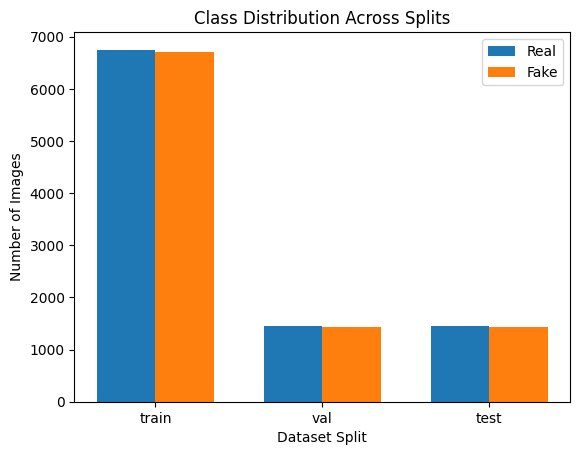

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

working_path = "/content/data"

splits = ["train", "val", "test"]

real_counts = []
fake_counts = []

for split in splits:
    real_counts.append(len(os.listdir(os.path.join(working_path, split, "real"))))
    fake_counts.append(len(os.listdir(os.path.join(working_path, split, "fake"))))

x = np.arange(len(splits))
width = 0.35

plt.figure()
plt.bar(x - width/2, real_counts, width, label='Real')
plt.bar(x + width/2, fake_counts, width, label='Fake')

plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.title("Class Distribution Across Splits")
plt.xticks(x, splits)
plt.legend()
plt.show()

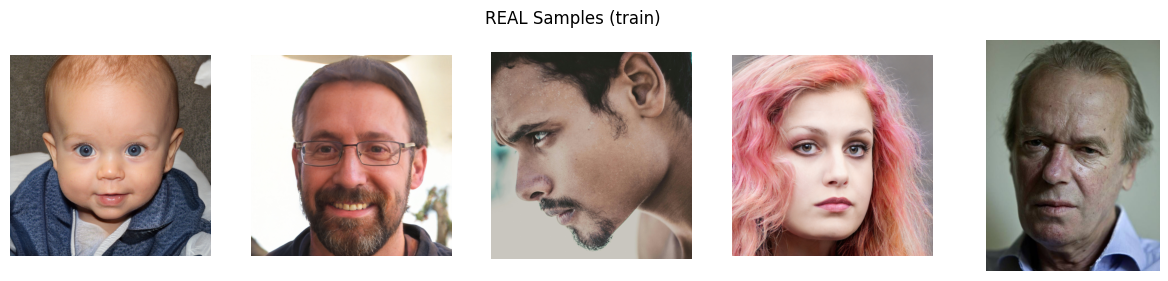

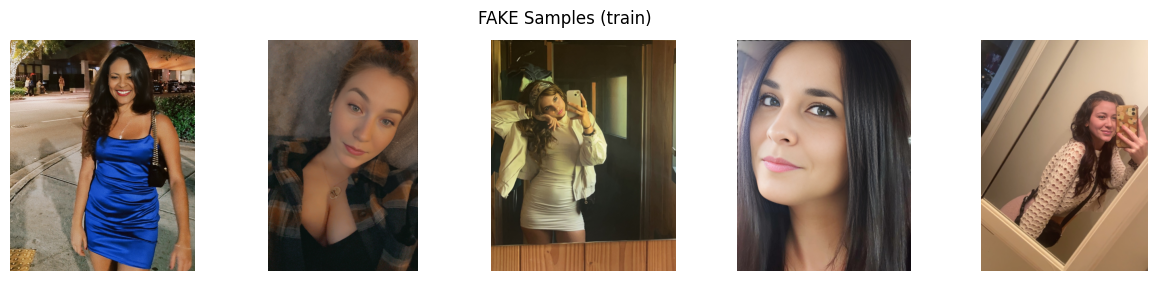

In [ ]:
from PIL import Image
import random

def show_samples(category, split="train", n=5):
    path = os.path.join(working_path, split, category)
    images = random.sample(os.listdir(path), n)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(path, img_name))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"{category.upper()} Samples ({split})")
    plt.show()

show_samples("real")
show_samples("fake")

In [ ]:
import numpy as np

def get_image_sizes(split="train", sample_size=500):
    sizes = []
    real_path = os.path.join(working_path, split, "real")
    fake_path = os.path.join(working_path, split, "fake")

    real_imgs = random.sample(os.listdir(real_path), min(sample_size, len(os.listdir(real_path))))
    fake_imgs = random.sample(os.listdir(fake_path), min(sample_size, len(os.listdir(fake_path))))

    for img_name in real_imgs:
        img = Image.open(os.path.join(real_path, img_name))
        sizes.append(img.size)

    for img_name in fake_imgs:
        img = Image.open(os.path.join(fake_path, img_name))
        sizes.append(img.size)

    return sizes

sizes = get_image_sizes()

widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

print("Mean Width:", np.mean(widths))
print("Mean Height:", np.mean(heights))
print("Min Width:", np.min(widths))
print("Min Height:", np.min(heights))
print("Max Width:", np.max(widths))
print("Max Height:", np.max(heights))

Mean Width: 1004.772
Mean Height: 1268.706
Min Width: 89
Min Height: 104
Max Width: 5472
Max Height: 5616


In [ ]:
def check_corrupted(folder):
    corrupted = []
    for file in os.listdir(folder):
        try:
            img = Image.open(os.path.join(folder, file))
            img.verify()
        except:
            corrupted.append(file)
    return corrupted

corrupted_real = check_corrupted(os.path.join(working_path, "train", "real"))
corrupted_fake = check_corrupted(os.path.join(working_path, "train", "fake"))

print("Corrupted real images:", len(corrupted_real))
print("Corrupted fake images:", len(corrupted_fake))

Corrupted real images: 0
Corrupted fake images: 0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
data_path = "/content/data"

train_dataset = datasets.ImageFolder(
    root=f"{data_path}/train",
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=f"{data_path}/val",
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=f"{data_path}/test",
    transform=val_test_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [ ]:
num_epochs = 2
best_val_loss = float("inf")
patience = 2
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_auc = roc_auc_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val AUC: {val_auc:.4f}")
    print("-"*30)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

Epoch [1/5]
Train Loss: 0.4154
Val Loss: 0.2693
Val AUC: 0.9889
------------------------------


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "resnet50_epoch1.pth")

In [ ]:
from google.colab import files
files.download("resnet50_epoch1.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load("resnet50_epoch1.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# AUC
test_auc = roc_auc_score(all_labels, all_preds)

# Threshold = 0.5 (for now)
binary_preds = (all_preds > 0.5).astype(int)

accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)

print("Test AUC:", test_auc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Test AUC: 0.9931656165733438
Accuracy: 0.955617198335645
Precision: 0.9796363636363636
Recall: 0.9308914996544575
F1 Score: 0.9546420978029766


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, binary_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1409   28]
 [ 100 1347]]


In [ ]:
np.save("resnet_test_preds.npy", all_preds)
np.save("resnet_test_labels.npy", all_labels)

In [ ]:
np.save("resnet_test_preds.npy", all_preds)
np.save("resnet_test_labels.npy", all_labels)

In [ ]:
!pip install scipy

In [ ]:
import numpy as np
import os
from PIL import Image
from scipy.fftpack import dct
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

In [ ]:
def extract_dct_features(folder_path, label, max_images=None):
    features = []
    labels = []

    image_files = os.listdir(folder_path)

    if max_images:
        image_files = image_files[:max_images]

    for file in image_files:
        img_path = os.path.join(folder_path, file)

        try:
            img = Image.open(img_path).convert("L")
            img = img.resize((128, 128))
            img_array = np.array(img)

            dct_coeff = dct2(img_array)

            # Take top-left 20x20 block (low frequency)
            dct_low = dct_coeff[:20, :20]
            features.append(dct_low.flatten())
            labels.append(label)

        except:
            continue

    return features, labels

In [ ]:
data_path = "/content/data"

# Train
train_real_features, train_real_labels = extract_dct_features(
    os.path.join(data_path, "train", "real"), label=0
)

train_fake_features, train_fake_labels = extract_dct_features(
    os.path.join(data_path, "train", "fake"), label=1
)

# Combine
X_train = np.array(train_real_features + train_fake_features)
y_train = np.array(train_real_labels + train_fake_labels)

print("Train feature shape:", X_train.shape)

Train feature shape: (13453, 400)


In [ ]:
val_real_features, val_real_labels = extract_dct_features(
    os.path.join(data_path, "val", "real"), label=0
)

val_fake_features, val_fake_labels = extract_dct_features(
    os.path.join(data_path, "val", "fake"), label=1
)

X_val = np.array(val_real_features + val_fake_features)
y_val = np.array(val_real_labels + val_fake_labels)

print("Validation feature shape:", X_val.shape)

Validation feature shape: (2882, 400)


In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
val_probs = clf.predict_proba(X_val)[:, 1]

val_auc = roc_auc_score(y_val, val_probs)
val_preds = (val_probs > 0.5).astype(int)

print("Validation AUC:", val_auc)
print("Accuracy:", accuracy_score(y_val, val_preds))
print("Precision:", precision_score(y_val, val_preds))
print("Recall:", recall_score(y_val, val_preds))
print("F1:", f1_score(y_val, val_preds))

Validation AUC: 0.8858574417180041
Accuracy: 0.8108952116585705
Precision: 0.7936717205009888
Recall: 0.8384401114206128
F1: 0.81544192346766


In [ ]:
test_real_features, test_real_labels = extract_dct_features(
    os.path.join(data_path, "test", "real"), label=0
)

test_fake_features, test_fake_labels = extract_dct_features(
    os.path.join(data_path, "test", "fake"), label=1
)

X_test = np.array(test_real_features + test_fake_features)
y_test = np.array(test_real_labels + test_fake_labels)

test_probs = clf.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probs)
test_preds = (test_probs > 0.5).astype(int)

print("Test AUC:", test_auc)
print("Accuracy:", accuracy_score(y_test, test_preds))
print("Precision:", precision_score(y_test, test_preds))
print("Recall:", recall_score(y_test, test_preds))
print("F1:", f1_score(y_test, test_preds))

Test AUC: 0.8970437239911337
Accuracy: 0.8294036061026352
Precision: 0.8011472275334608
Recall: 0.8747390396659708
F1: 0.8363273453093812


In [ ]:
np.save("dct_test_probs.npy", test_probs)
np.save("dct_test_labels.npy", y_test)

In [ ]:
from google.colab import files
files.download("dct_test_probs.npy")
files.download("dct_test_labels.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.eval()

resnet_val_preds = []
resnet_val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        resnet_val_preds.extend(probs.cpu().numpy())
        resnet_val_labels.extend(labels.cpu().numpy())

resnet_val_preds = np.array(resnet_val_preds)
resnet_val_labels = np.array(resnet_val_labels)

print("Validation predictions shape:", resnet_val_preds.shape)

Validation predictions shape: (2882, 1)


In [ ]:
np.save("resnet_val_preds.npy", resnet_val_preds)
np.save("resnet_val_labels.npy", resnet_val_labels)

In [ ]:
print("CNN labels shape:", resnet_val_labels.shape)
print("DCT labels shape:", y_val.shape)

CNN labels shape: (2882, 1)
DCT labels shape: (2882,)


In [ ]:
X_val_meta = np.column_stack((resnet_val_preds.flatten(), dct_val.flatten()))
X_test_meta = np.column_stack((resnet_test.flatten(), dct_test.flatten()))

print("Meta val shape:", X_val_meta.shape)

NameError: name 'dct_val' is not defined

In [ ]:
# Recompute DCT validation probabilities
dct_val = clf.predict_proba(X_val)[:, 1]

print("DCT validation shape:", dct_val.shape)

DCT validation shape: (2882,)


In [ ]:
# Only if X_val missing
val_real_features, val_real_labels = extract_dct_features(
    os.path.join(data_path, "val", "real"), label=0
)

val_fake_features, val_fake_labels = extract_dct_features(
    os.path.join(data_path, "val", "fake"), label=1
)

X_val = np.array(val_real_features + val_fake_features)
y_val = np.array(val_real_labels + val_fake_labels)

dct_val = clf.predict_proba(X_val)[:, 1]

In [ ]:
print(resnet_val_preds.shape)

(2882, 1)


In [ ]:
resnet_val_preds = resnet_val_preds.flatten()

In [ ]:
X_val_meta = np.column_stack((resnet_val_preds.flatten(), dct_val.flatten()))
X_test_meta = np.column_stack((resnet_test.flatten(), dct_test.flatten()))

print("Meta validation shape:", X_val_meta.shape)
print("Meta test shape:", X_test_meta.shape)

NameError: name 'resnet_test' is not defined

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)

rf.fit(X_val_meta, y_val)

RandomForestClassifier(max_depth=3, random_state=42)

In [ ]:
rf_probs = rf.predict_proba(X_test_meta)[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

rf_auc = roc_auc_score(y_test, rf_probs)
rf_acc = accuracy_score(y_test, rf_preds)
rf_prec = precision_score(y_test, rf_preds)
rf_rec = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)

print("Random Forest Ensemble Results")
print("AUC:", rf_auc)
print("Accuracy:", rf_acc)
print("Precision:", rf_prec)
print("Recall:", rf_rec)
print("F1:", rf_f1)

NameError: name 'X_test_meta' is not defined

In [ ]:
resnet_test_preds.npy

NameError: name 'resnet_test_preds' is not defined

In [ ]:
resnet_test = np.load("resnet_test_preds.npy")
resnet_test = resnet_test.flatten()

print("ResNet test shape:", resnet_test.shape)

ResNet test shape: (2884,)


In [ ]:
dct_test = np.load("dct_test_probs.npy")
dct_test = dct_test.flatten()

print("DCT test shape:", dct_test.shape)

DCT test shape: (2884,)


In [ ]:
y_test = np.load("dct_test_labels.npy")
print("Test labels shape:", y_test.shape)

Test labels shape: (2884,)


In [ ]:
X_test_meta = np.column_stack((resnet_test, dct_test))

print("Meta test shape:", X_test_meta.shape)

Meta test shape: (2884, 2)


In [ ]:
rf_probs = rf.predict_proba(X_test_meta)[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

rf_auc = roc_auc_score(y_test, rf_probs)
rf_acc = accuracy_score(y_test, rf_preds)
rf_prec = precision_score(y_test, rf_preds)
rf_rec = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)

print("Random Forest Ensemble Results")
print("AUC:", rf_auc)
print("Accuracy:", rf_acc)
print("Precision:", rf_prec)
print("Recall:", rf_rec)
print("F1:", rf_f1)

Random Forest Ensemble Results
AUC: 0.9947786291701354
Accuracy: 0.9694868238557559
Precision: 0.9773531493276716
Recall: 0.9610299234516354
F1: 0.9691228070175438


In [ ]:
import joblib

joblib.dump(rf, "random_forest_ensemble.pkl")

['random_forest_ensemble.pkl']

In [ ]:
np.save("ensemble_X_test.npy", X_test_meta)
np.save("ensemble_y_test.npy", y_test)

In [ ]:
np.save("ensemble_test_probs.npy", rf_probs)
np.save("ensemble_test_preds.npy", rf_preds)

In [ ]:
import json

ensemble_metrics = {
    "AUC": float(rf_auc),
    "Accuracy": float(rf_acc),
    "Precision": float(rf_prec),
    "Recall": float(rf_rec),
    "F1": float(rf_f1)
}

with open("ensemble_metrics.json", "w") as f:
    json.dump(ensemble_metrics, f, indent=4)

print("Metrics saved.")

Metrics saved.


In [ ]:
from google.colab import files

files.download("random_forest_ensemble.pkl")
files.download("ensemble_metrics.json")
files.download("ensemble_test_probs.npy")
files.download("ensemble_test_preds.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(clf, "dct_logistic_model.pkl")
files.download("dct_logistic_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

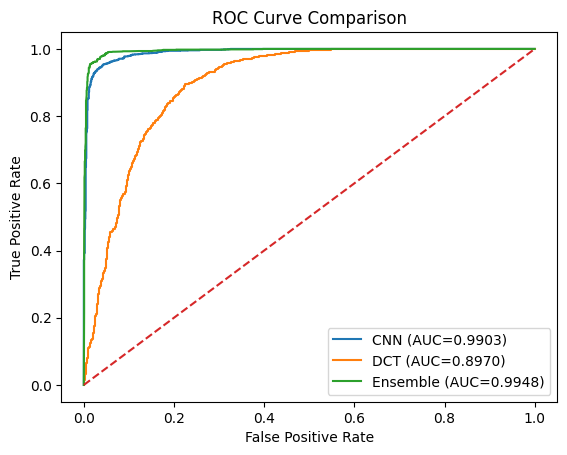

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, resnet_test)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# DCT
fpr_dct, tpr_dct, _ = roc_curve(y_test, dct_test)
auc_dct = auc(fpr_dct, tpr_dct)

# Ensemble
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC={auc_cnn:.4f})")
plt.plot(fpr_dct, tpr_dct, label=f"DCT (AUC={auc_dct:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Ensemble (AUC={auc_rf:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

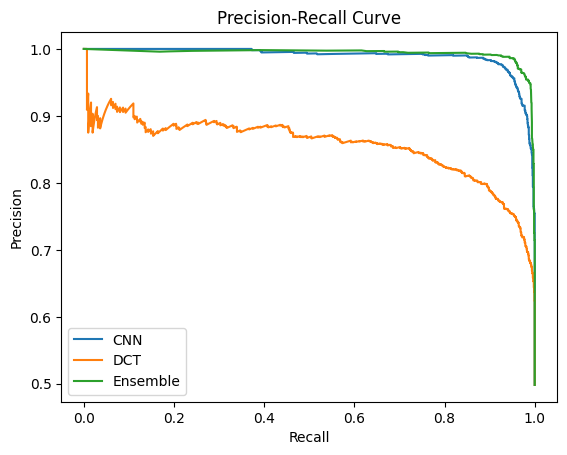

In [ ]:
from sklearn.metrics import precision_recall_curve

# CNN
prec_cnn, rec_cnn, _ = precision_recall_curve(y_test, resnet_test)

# DCT
prec_dct, rec_dct, _ = precision_recall_curve(y_test, dct_test)

# Ensemble
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_probs)

plt.figure()
plt.plot(rec_cnn, prec_cnn, label="CNN")
plt.plot(rec_dct, prec_dct, label="DCT")
plt.plot(rec_rf, prec_rf, label="Ensemble")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

# CNN binary predictions
cnn_preds = (resnet_test > 0.5).astype(int)

# Ensemble binary predictions
rf_binary = (rf_probs > 0.5).astype(int)

# Build contingency table
table = [[0, 0], [0, 0]]

for i in range(len(y_test)):
    if cnn_preds[i] == y_test[i] and rf_binary[i] == y_test[i]:
        table[0][0] += 1
    elif cnn_preds[i] == y_test[i] and rf_binary[i] != y_test[i]:
        table[0][1] += 1
    elif cnn_preds[i] != y_test[i] and rf_binary[i] == y_test[i]:
        table[1][0] += 1
    else:
        table[1][1] += 1

result = mcnemar(table, exact=False)
print("McNemar p-value:", result.pvalue)

ModuleNotFoundError: No module named 'statsmodels'

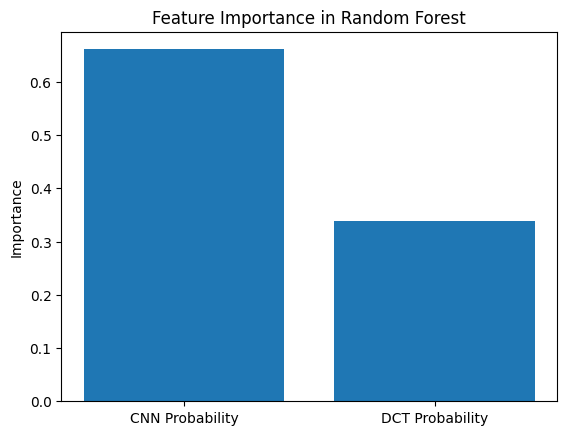

In [ ]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = ["CNN Probability", "DCT Probability"]

plt.figure()
plt.bar(features, importances)
plt.title("Feature Importance in Random Forest")
plt.ylabel("Importance")
plt.show()

In [ ]:
import torch
import numpy as np

def get_patch_predictions(loader, model, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            batch_probs = []

            for img in images:
                # img shape: [3, 224, 224]
                patches = []

                # Split into 4 patches
                patches.append(img[:, 0:112, 0:112])
                patches.append(img[:, 0:112, 112:224])
                patches.append(img[:, 112:224, 0:112])
                patches.append(img[:, 112:224, 112:224])

                patches = torch.stack(patches).to(device)

                outputs = model(patches)
                probs = torch.sigmoid(outputs)

                # Average patch probabilities
                avg_prob = probs.mean().item()
                batch_probs.append(avg_prob)

            all_probs.extend(batch_probs)
            all_labels.extend(labels.cpu().numpy().flatten())

    return np.array(all_probs), np.array(all_labels)

In [ ]:
patch_val_probs, patch_val_labels = get_patch_predictions(val_loader, model, device)

print("Patch validation shape:", patch_val_probs.shape)

Patch validation shape: (2882,)


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

val_auc_patch = roc_auc_score(patch_val_labels, patch_val_probs)
val_preds_patch = (patch_val_probs > 0.5).astype(int)

print("Patch Model Validation Results")
print("AUC:", val_auc_patch)
print("Accuracy:", accuracy_score(patch_val_labels, val_preds_patch))
print("Recall:", recall_score(patch_val_labels, val_preds_patch))

Patch Model Validation Results
AUC: 0.9896886810989494
Accuracy: 0.9368494101318529
Recall: 0.8879668049792531


In [ ]:
patch_test_probs, patch_test_labels = get_patch_predictions(test_loader, model, device)

test_auc_patch = roc_auc_score(patch_test_labels, patch_test_probs)
test_preds_patch = (patch_test_probs > 0.5).astype(int)

print("Patch Model Test Results")
print("AUC:", test_auc_patch)
print("Accuracy:", accuracy_score(patch_test_labels, test_preds_patch))
print("Recall:", recall_score(patch_test_labels, test_preds_patch))
print("F1:", f1_score(patch_test_labels, test_preds_patch))

Patch Model Test Results
AUC: 0.9906912725630597
Accuracy: 0.9420943134535368
Recall: 0.899101589495508
F1: 0.939689418562658


In [ ]:
np.save("patch_val_probs.npy", patch_val_probs)
np.save("patch_test_probs.npy", patch_test_probs)

In [ ]:
# Flatten all
resnet_val_flat = resnet_val_preds.flatten()
dct_val_flat = dct_val.flatten()
patch_val_flat = patch_val_probs.flatten()

resnet_test_flat = resnet_test.flatten()
dct_test_flat = dct_test.flatten()
patch_test_flat = patch_test_probs.flatten()

# Stack 3 features
X_val_meta_3 = np.column_stack((resnet_val_flat, dct_val_flat, patch_val_flat))
X_test_meta_3 = np.column_stack((resnet_test_flat, dct_test_flat, patch_test_flat))

print("3-model meta val shape:", X_val_meta_3.shape)

3-model meta val shape: (2882, 3)


In [ ]:
rf3 = RandomForestClassifier(
    n_estimators=150,
    max_depth=4,
    random_state=42
)

rf3.fit(X_val_meta_3, y_val)

RandomForestClassifier(max_depth=4, n_estimators=150, random_state=42)

In [ ]:
rf3_probs = rf3.predict_proba(X_test_meta_3)[:, 1]
rf3_preds = (rf3_probs > 0.5).astype(int)

rf3_auc = roc_auc_score(y_test, rf3_probs)
rf3_acc = accuracy_score(y_test, rf3_preds)
rf3_rec = recall_score(y_test, rf3_preds)
rf3_f1 = f1_score(y_test, rf3_preds)

print("3-Model Ensemble Results")
print("AUC:", rf3_auc)
print("Accuracy:", rf3_acc)
print("Recall:", rf3_rec)
print("F1:", rf3_f1)

3-Model Ensemble Results
AUC: 0.9954930388936098
Accuracy: 0.9722607489597781
Recall: 0.9672929714683368
F1: 0.972027972027972


In [ ]:
import joblib
import torch

# Save CNN
torch.save(model.state_dict(), "cnn_resnet50_epoch1.pth")

# Save DCT logistic regression
joblib.dump(clf, "dct_logistic_model.pkl")

# Save 2-model RF
joblib.dump(rf, "rf_2model.pkl")

# Save 3-model RF
joblib.dump(rf3, "rf_3model.pkl")

print("All models saved.")

All models saved.


In [ ]:
import numpy as np

# CNN
np.save("resnet_val_preds.npy", resnet_val_flat)
np.save("resnet_test_preds.npy", resnet_test_flat)

# DCT
np.save("dct_val_probs.npy", dct_val_flat)
np.save("dct_test_probs.npy", dct_test_flat)

# Patch
np.save("patch_val_probs.npy", patch_val_flat)
np.save("patch_test_probs.npy", patch_test_flat)

# Ensemble outputs
np.save("rf2_test_probs.npy", rf_probs)
np.save("rf3_test_probs.npy", rf3_probs)

# Labels
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)

print("All prediction arrays saved.")

All prediction arrays saved.


In [ ]:
import json

final_results = {
    "CNN": {
        "AUC": 0.9931656165733438,
        "Accuracy": 0.955617198335645
    },
    "DCT": {
        "AUC": 0.8970437239911337,
        "Accuracy": 0.8294036061026352
    },
    "Patch": {
        "AUC": 0.9906912725630597,
        "Accuracy": 0.9420943134535368
    },
    "RF_2model": {
        "AUC": 0.9947786291701354,
        "Accuracy": 0.9694868238557559
    },
    "RF_3model": {
        "AUC": float(rf3_auc),
        "Accuracy": float(rf3_acc),
        "Recall": float(rf3_rec),
        "F1": float(rf3_f1)
    }
}

with open("final_results.json", "w") as f:
    json.dump(final_results, f, indent=4)

print("Metrics saved.")

Metrics saved.


In [ ]:
import zipfile
import os

files_to_zip = [
    "cnn_resnet50_epoch1.pth",
    "dct_logistic_model.pkl",
    "rf_2model.pkl",
    "rf_3model.pkl",
    "resnet_val_preds.npy",
    "resnet_test_preds.npy",
    "dct_val_probs.npy",
    "dct_test_probs.npy",
    "patch_val_probs.npy",
    "patch_test_probs.npy",
    "rf2_test_probs.npy",
    "rf3_test_probs.npy",
    "y_val.npy",
    "y_test.npy",
    "final_results.json"
]

with zipfile.ZipFile("deepfake_ensemble_project.zip", "w") as z:
    for file in files_to_zip:
        if os.path.exists(file):
            z.write(file)

print("ZIP file created.")

ZIP file created.


In [ ]:
from google.colab import files
files.download("deepfake_ensemble_project.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

# CNN predictions
cnn_preds = (resnet_test > 0.5).astype(int)

# 3-model Ensemble predictions
ensemble_preds = (rf3_probs > 0.5).astype(int)

# Build contingency table
#            Ensemble Correct   Ensemble Wrong
# CNN Correct       a                 b
# CNN Wrong         c                 d

a = b = c = d = 0

for i in range(len(y_test)):
    cnn_correct = (cnn_preds[i] == y_test[i])
    ens_correct = (ensemble_preds[i] == y_test[i])

    if cnn_correct and ens_correct:
        a += 1
    elif cnn_correct and not ens_correct:
        b += 1
    elif not cnn_correct and ens_correct:
        c += 1
    else:
        d += 1

table = [[a, b],
         [c, d]]

print("Contingency Table:", table)

result = mcnemar(table, exact=False)
print("McNemar p-value:", result.pvalue)

NameError: name 'resnet_test' is not defined

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving y_test.npy to y_test.npy
Saving rf3_test_probs.npy to rf3_test_probs.npy
Saving resnet_test_preds.npy to resnet_test_preds.npy


In [ ]:
import numpy as np

resnet_test = np.load("resnet_test_preds.npy").flatten()
rf3_probs = np.load("rf3_test_probs.npy").flatten()
y_test = np.load("y_test.npy")

print("Loaded shapes:")
print(resnet_test.shape, rf3_probs.shape, y_test.shape)

Loaded shapes:
(2884,) (2884,) (2884,)


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

# Convert probabilities to binary predictions
cnn_preds = (resnet_test > 0.5).astype(int)
ensemble_preds = (rf3_probs > 0.5).astype(int)

# Build contingency table
a = b = c = d = 0

for i in range(len(y_test)):
    cnn_correct = (cnn_preds[i] == y_test[i])
    ens_correct = (ensemble_preds[i] == y_test[i])

    if cnn_correct and ens_correct:
        a += 1
    elif cnn_correct and not ens_correct:
        b += 1
    elif not cnn_correct and ens_correct:
        c += 1
    else:
        d += 1

table = [[a, b],
         [c, d]]

print("Contingency Table:", table)

result = mcnemar(table, exact=False)
print("McNemar p-value:", result.pvalue)

Contingency Table: [[2733, 15], [71, 65]]
McNemar p-value: 3.014575962759146e-09


In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
print("Dataset path:", path)

Using Colab cache for faster access to the '140k-real-and-fake-faces' dataset.
Dataset path: /kaggle/input/140k-real-and-fake-faces


In [ ]:
nested_root = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

print("Inside nested folder:")
print(os.listdir(nested_root))

Inside nested folder:
['valid', 'test', 'train']


In [ ]:
import os

nested_root = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

test_path = os.path.join(nested_root, "test")

print("Inside test folder:")
print(os.listdir(test_path))

Inside test folder:
['fake', 'real']


In [ ]:
real_path = os.path.join(test_path, "real")
fake_path = os.path.join(test_path, "fake")

print("Real exists:", os.path.exists(real_path))
print("Fake exists:", os.path.exists(fake_path))

Real exists: True
Fake exists: True


In [ ]:
real_files = os.listdir(real_path)[:500]
fake_files = os.listdir(fake_path)[:500]

print("Using", len(real_files), "real and", len(fake_files), "fake images")

Using 500 real and 500 fake images


In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
from scipy.fftpack import dct
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

cnn_probs = []
patch_probs = []
dct_probs = []
all_labels = []

def process_image(img_path, label):
    img = Image.open(img_path).convert("RGB")

    # ---- CNN ----
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        cnn_out = torch.sigmoid(model(img_tensor)).item()

    # ---- Patch ----
    img_resized = transform(img)
    patches = [
        img_resized[:,0:112,0:112],
        img_resized[:,0:112,112:224],
        img_resized[:,112:224,0:112],
        img_resized[:,112:224,112:224]
    ]
    patches = torch.stack(patches).to(device)
    with torch.no_grad():
        patch_out = torch.sigmoid(model(patches)).mean().item()

    # ---- DCT ----
    img_gray = img.convert("L").resize((128,128))
    img_array = np.array(img_gray)
    dct_coeff = dct2(img_array)
    dct_feat = dct_coeff[:20,:20].flatten().reshape(1,-1)
    dct_out = clf.predict_proba(dct_feat)[:,1][0]

    cnn_probs.append(cnn_out)
    patch_probs.append(patch_out)
    dct_probs.append(dct_out)
    all_labels.append(label)

# Process Real images
for file in real_files:
    process_image(os.path.join(real_path, file), 0)

# Process Fake images
for file in fake_files:
    process_image(os.path.join(fake_path, file), 1)

# Convert to numpy
cnn_probs = np.array(cnn_probs)
patch_probs = np.array(patch_probs)
dct_probs = np.array(dct_probs)
all_labels = np.array(all_labels)

# ---- 3-Model Ensemble ----
X_meta = np.column_stack((cnn_probs, dct_probs, patch_probs))

rf_probs = rf3.predict_proba(X_meta)[:,1]
rf_preds = (rf_probs > 0.5).astype(int)

print("Cross-Dataset Results (1000 images)")
print("AUC:", roc_auc_score(all_labels, rf_probs))
print("Accuracy:", accuracy_score(all_labels, rf_preds))
print("Recall:", recall_score(all_labels, rf_preds))
print("F1:", f1_score(all_labels, rf_preds))

NameError: name 'model' is not defined

In [ ]:
from google.colab import files
files.upload()

Saving rf_3model.pkl to rf_3model.pkl
Saving rf_2model.pkl to rf_2model.pkl
Saving dct_logistic_model.pkl to dct_logistic_model.pkl
Saving cnn_resnet50_epoch1.pth to cnn_resnet50_epoch1.pth
Buffered data was truncated after reaching the output size limit.

In [ ]:
import torch
import joblib
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Load CNN -----
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("cnn_resnet50_epoch1.pth", map_location=device))
model = model.to(device)
model.eval()

print("CNN loaded")

# ----- Load DCT model -----
clf = joblib.load("dct_logistic_model.pkl")
print("DCT model loaded")

# ----- Load Ensemble -----
rf3 = joblib.load("rf_3model.pkl")
print("RF3 loaded")